In [1]:
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from tensorflow import keras
import tensorflow as tf
from keras.applications import VGG16
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
TRAIN_PATH = "./Training/"
TEST_PATH = "./Testing/"
img_width, img_height = 224, 224
channels = 3
batch_size = 64
num_images= 20
image_arr_size= img_width * img_height * channels
DPI = 900

In [3]:
train_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    rotation_range = 15,
    width_shift_range = 0.1,
    zoom_range = 0.01,
    shear_range = 0.01,
    brightness_range = [0.3, 1.5],
    horizontal_flip = True,
    vertical_flip = True
)
valid_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.2)

In [4]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    subset='training',
    shuffle= True,
    seed= 1337
)

valid_generator = valid_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    subset='validation',
    shuffle= True,
    seed= 1337
)

Found 5712 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [5]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, channels))
for layer in base_model.layers:
    layer.trainable = False  # freeze backbone

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x) 

In [6]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Theo dõi loss trên tập validation
    patience=10,  # Dừng nếu val_loss không giảm sau 10 epochs
    restore_best_weights=True,  # Lấy lại model tốt nhất
    min_delta=1e-4  # Chỉ dừng nếu giảm không đáng kể
)

callbacks = [early_stopping]

In [8]:
history = model.fit(
    train_generator,
    epochs = 100,
    validation_data = valid_generator,
    verbose = 1,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/100


D:\Users\Desktop\hocmay\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 654s 7s/step - accuracy: 0.5670 - loss: 1.0698 - val_accuracy: 0.7783 - val_loss: 0.6418
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 528s 6s/step - accuracy: 0.7964 - loss: 0.5617 - val_accuracy: 0.8124 - val_loss: 0.5017
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 482s 5s/step - accuracy: 0.8205 - loss: 0.4885 - val_accuracy: 0.8151 - val_loss: 0.4893
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 528s 6s/step - accuracy: 0.8325 - loss: 0.4391 - val_accuracy: 0.8344 - val_loss: 0.4435
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 546s 6s/step - accuracy: 0.8561 - loss: 0.3944 - val_accuracy: 0.8449 - val_loss: 0.4234
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 527s 6s/step - accuracy: 0.8523 - loss: 0.4109 - val_accuracy: 0.8475 - val_loss: 0.3889
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 487s 5s/step - accuracy: 0.8602 - loss: 0.3843 - val_accuracy: 0.8668 - val_loss: 0.3634
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 484s 5s/step - accuracy: 0.8790 - loss: 0.3416 - val_accuracy: 0.8642 - val_l

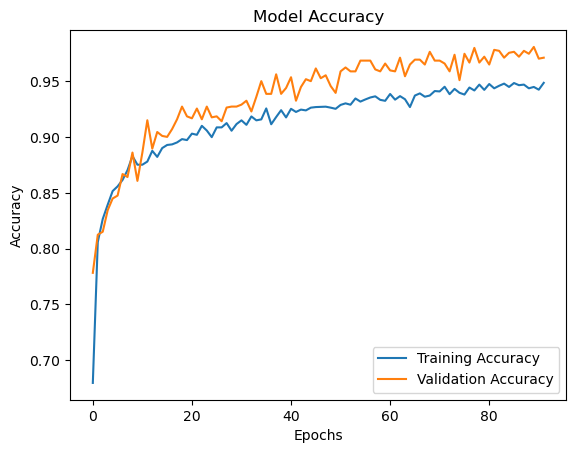

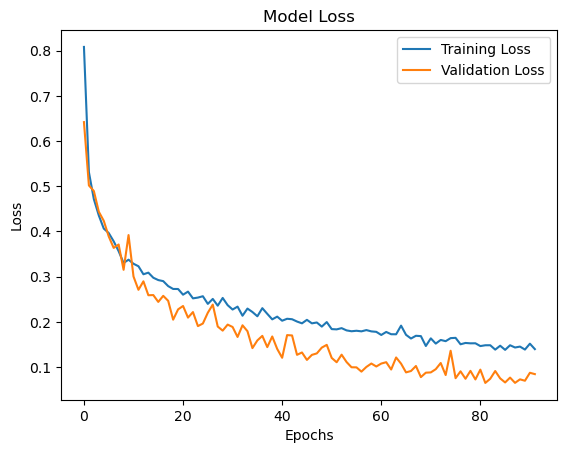

In [9]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= DPI)
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= DPI)
plt.show()

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,         
    target_size=(224, 224),       
    batch_size=batch_size,
    class_mode='categorical',          
    shuffle=False                 
)
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

Found 1311 images belonging to 4 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 94s 5s/step - accuracy: 0.9363 - loss: 0.1616


In [11]:
loss, accuracy

(0.11241376399993896, 0.957812488079071)